# MSE Time Series and Advection
This looks at how near-surface MSE develops with time throughout the year

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-09-18 14:25:38,610 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'precipitation', 'omega', 'ucomp', 'vcomp', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t']  
# Load dataset
tau_lw = [1]
n_exp = len(tau_lw)
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_dir = 'aquaplanet/no_wishe/'
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# exp_dir = 'rossbypalooza/variable_evap_flux/evap=0/'
# exp_name=''

use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

Removing height from var_keep


In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [18]:
lat_plot = 80
p_surface_approx = 1000
p_ft_approx = 500
ds = annual_mean(ds_base[0].sel(lat=lat_plot, method='nearest').sel(pfull=p_surface_approx, method='nearest')).mean(dim='lon')
ds_ft = annual_mean(ds_base[0][['temp', 'vcomp']].sel(lat=lat_plot, method='nearest').sel(pfull=p_ft_approx, method='nearest')).mean(dim='lon')
p_surface = float(ds.pfull)*100
p_ft = float(ds_ft.pfull)*100
ds = ds.assign_coords(time=(ds.time - ds.time.min()).astype(int)).load()
ds_ft = ds_ft.assign_coords(time=(ds_ft.time - ds_ft.time.min()).astype(int)).load()

## Empirical Fitting
To get solution for temperature time-series, we need to represent $\Gamma^{\uparrow} = LW^{\uparrow} - LW^{\downarrow} + SH^{\uparrow} + LH^{\uparrow}$ as a function of temperature.

E.g. we want $\Gamma^{\uparrow} \approx \lambda_0 + \lambda_1 T + \lambda_2 T^2$

So the equation including the $T^2$ is: 

$C\frac{\partial T}{\partial t} \approx F_s(t) - \lambda_0 - \lambda_1 T - \lambda_2 T^2$ where $F_s(t) \approx F_0 + F_1\cos(2\pi ft) + \frac{F_2}{F_1}F_1\cos(4\pi ft)$

In [19]:
r_surf = np.asarray(ds.sphum/sphum_sat(ds.temp, p_surface))
temp_surf_conv = np.zeros(ds.time.size)
for i in tqdm(range(ds.time.size)):
    temp_surf_conv[i] = get_temp_adiabat_surf(r_surf[i], float(ds_ft.temp[i]), None, p_surface, p_ft, True)

  0%|          | 0/360 [00:00<?, ?it/s]/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_72589/1932096535.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp_surf_conv[i] = get_temp_adiabat_surf(r_surf[i], float(ds_ft.temp[i]), None, p_surface, p_ft, True)
100%|██████████| 360/360 [00:00<00:00, 5682.38it/s]


In [20]:
def linear_func(x_var, a, b):
    return a + b*x_var

def square_func(x_var, a, b, c):
    return a + b*x_var + c*x_var**2

t_surf_anom = np.asarray(ds.temp-ds.temp.mean(dim='time'))
# t_surf_anom = np.asarray(ds.t_surf-ds.t_surf.mean(dim='time'))
gamma_up = np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t)
no_conv_time_ind = np.where(temp_surf_conv - ds.temp>1)[0]
# no_conv_time_ind = no_conv_time_ind[no_conv_time_ind<180]
lambda_empirical = {'linear': np.append(optimize.curve_fit(linear_func, t_surf_anom, gamma_up, [80, 3])[0], 0),
                    'linear_no_conv': np.append(optimize.curve_fit(linear_func, t_surf_anom[no_conv_time_ind], gamma_up[no_conv_time_ind], 
                                                                   [80, 3])[0], 0),
                    'square': optimize.curve_fit(square_func, t_surf_anom, gamma_up, [80, 3, 0])[0], 
                    'square_no_conv': optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], gamma_up[no_conv_time_ind], [80, 3, 0])[0]}

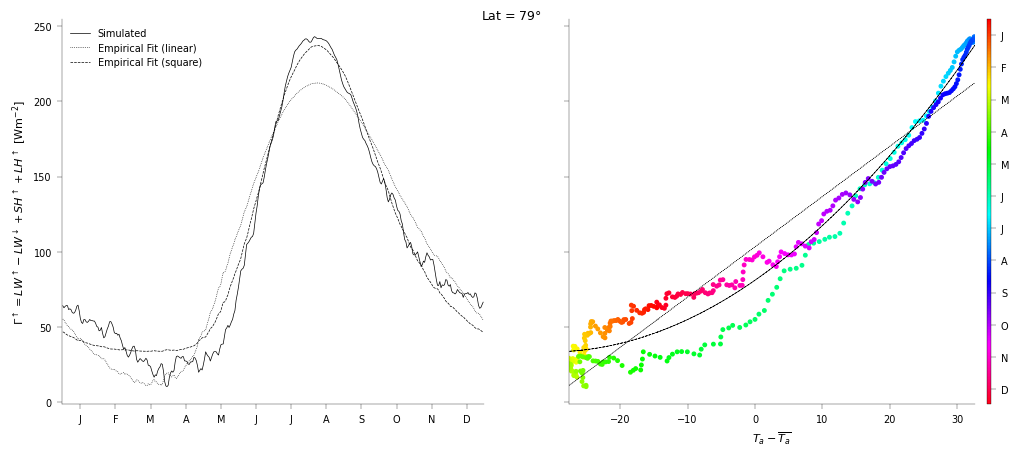

In [21]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
ax[0].plot(ds.time, gamma_up, color='k', label='Simulated')
ax[0].plot(ds.time, square_func(t_surf_anom, *lambda_empirical['linear']), color='k', linestyle=':', label='Empirical Fit (linear)')
ax[0].plot(ds.time, square_func(t_surf_anom, *lambda_empirical['square']), color='k', linestyle='--', label='Empirical Fit (square)')
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
im = ax[1].scatter(t_surf_anom, gamma_up, c=ds.time, cmap='hsv')
ax[1].plot(t_surf_anom, square_func(t_surf_anom, *lambda_empirical['linear']), 
           color='k', linestyle=':')
ax[1].plot(t_surf_anom, square_func(t_surf_anom, *lambda_empirical['square']), 
           color='k', linestyle='--')
cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[1].set_xlabel('$T_a - \overline{T_a}$')
ax[0].set_xlim(-1, 360)
ax[1].set_xlim(t_surf_anom.min(), t_surf_anom.max())
ax[0].legend()
ax[0].set_xticks(*month_ticks)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### Breakdown into $\lambda$ fitting for each surface flux

Here I fit $\lambda_0 + \lambda_1 T + \lambda_2 T^2$ to each of the individual fluxes that go into $\Gamma^{\uparrow}$. There seems to be a clear division in relationship for days before vs after the hottest day. I think this is because convection acts to give a phase delay.

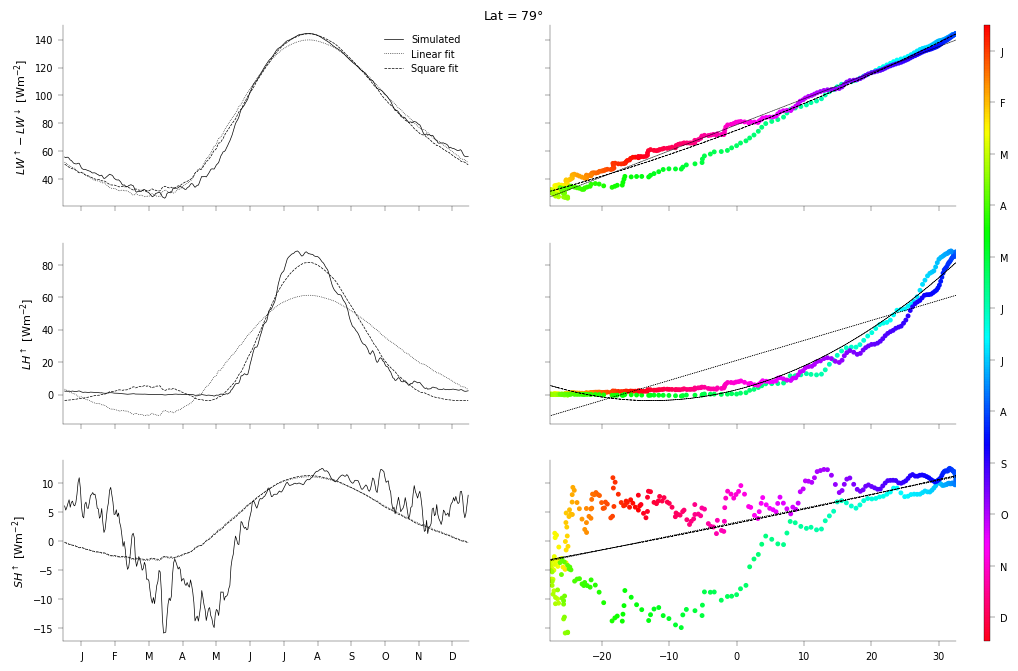

In [22]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey='row', sharex='col')
labels_use = ['$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]', '$LH^{\\uparrow}$ [Wm$^{-2}$]', '$SH^{\\uparrow}$ [Wm$^{-2}$]']
for i, var in enumerate([ds.lwup_sfc-ds.lwdn_sfc, ds.flux_lhe, ds.flux_t]):
    ax[i, 0].plot(ds.time, var, color='k', label='Simulated')
    im = ax[i, 1].scatter(t_surf_anom, var, c=ds.time, cmap='hsv')
    fit_param = optimize.curve_fit(linear_func, t_surf_anom, var, [80, 3])[0]
    ax[i, 0].plot(ds.time, linear_func(t_surf_anom, *fit_param), color='k', linestyle=':', label='Linear fit')
    ax[i, 1].plot(t_surf_anom, linear_func(t_surf_anom, *fit_param), color='k', linestyle=':')
    fit_param = optimize.curve_fit(square_func, t_surf_anom, var, [80, 3, 0])[0]
    ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='k', linestyle='--', label='Square fit')
    ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='k', linestyle='--')
    ax[i, 0].set_ylabel(labels_use[i])
    # fit_param = optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], var[no_conv_time_ind], [80, 3, 0])[0]
    # ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='g', linestyle='--', label='Square fit (non convecting)')
    # ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='g', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom.min(), t_surf_anom.max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### Difference between near-surface and surface temperature
At higher latitudes when convection not active, don't see this phase delay around hottest day. Difference from linear trend in longwave is due to surface and atmospheric temperatures being different. This is shown below.

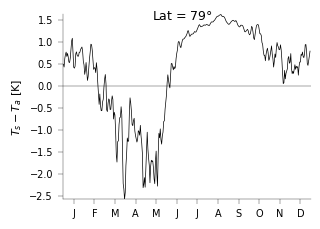

In [23]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(ds.t_surf-ds.temp, color='k')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylim((ds.t_surf-ds.temp).min(), (ds.t_surf-ds.temp).max())
ax.set_xticks(*month_ticks)
ax.set_xlim(-1, 360)
ax.set_ylabel('$T_s - T_a$ [K]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### Solution for $T(t)$
Let us seek a fourier series solution for $T(t)$ with two harmonics, so it is the same form as $F_s(t)$:
$$T(t) \approx T_0 + T_1\cos(2\pi ft - \phi_1) + T_2\cos(4\pi ft - \phi_2)$$

This is the exact solution to the equation if $\lambda_2=0$ but is not exact if $\lambda_2 \neq 0$.

In [24]:
def get_temp_fourier_coefs(time, sw_fourier_amp, sw_fourier_phase, lambda_const, heat_capacity, n_harmonics=2):
    n_year_days = len(time)
    sw_fourier = fourier.fourier_series(time, n_year_days, sw_fourier_amp, sw_fourier_phase)
    
    def surface_energy_lhs(time, *args):
        amp_args = [args[i] for i in range(n_harmonics+1)]
        phase_args = [args[i] for i in range(n_harmonics+1,len(args))]
        temp_fourier = fourier.fourier_series(time, n_year_days, amp_args, phase_args)
        return heat_capacity * fourier.fourier_series_deriv(time, n_year_days, amp_args, phase_args) + lambda_const[0] + \
            lambda_const[1] * temp_fourier + lambda_const[2] * temp_fourier**2
    
    args_found = optimize.curve_fit(surface_energy_lhs, time, sw_fourier, np.ones(2*n_harmonics+1))[0]
    return args_found[:n_harmonics+1], args_found[n_harmonics+1:]

In [25]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
sw_amp_coefs = fourier.get_fourier_fit(ds.time, ds.swdn_sfc, ds.time.size, 2)[1]
sw_phase_coefs = np.zeros(2)
sw_fourier_fit = fourier.fourier_series(ds.time, ds.time.size, sw_amp_coefs, sw_phase_coefs)
temp_amp_coefs = {}
temp_phase_coefs = {}
temp_fourier_fit = {}
for key in lambda_empirical:
    temp_amp_coefs[key], temp_phase_coefs[key] = get_temp_fourier_coefs(ds.time, sw_amp_coefs, sw_phase_coefs, 
                                                                    lambda_empirical[key], heat_capacity, n_harmonics=2)
    temp_fourier_fit[key] = fourier.fourier_series(ds.time, ds.time.size, temp_amp_coefs[key], temp_phase_coefs[key])

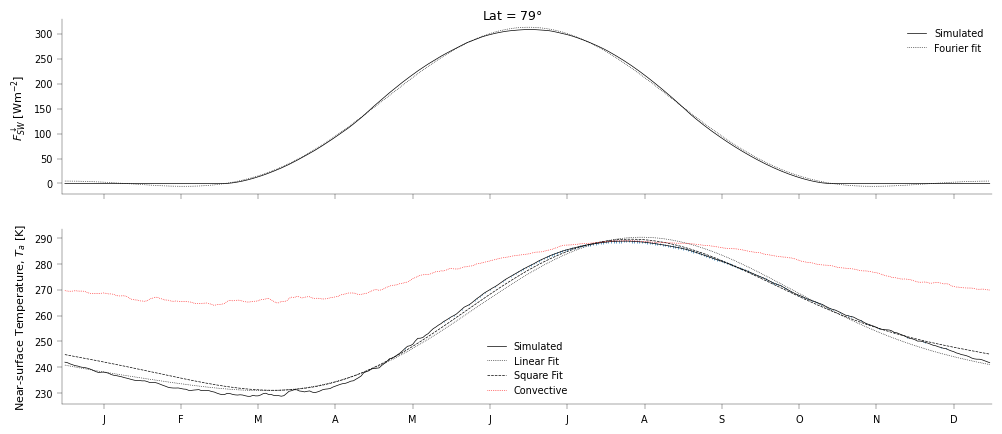

In [26]:
precip_marker_size_func = lambda x: (x*40000)**3        # how to relate precipitation to marker size

fig, ax = plt.subplots(2,1, figsize=(12, 5), sharex=True)
ax[0].plot(ds.time, ds.swdn_sfc, color='k', label='Simulated')
ax[0].plot(ds.time, sw_fourier_fit, color='k', linestyle=':', label='Fourier fit')
ax[1].plot(ds.time, ds.temp, color='k', label='Simulated')
ax[1].plot(ds.time, temp_fourier_fit['linear']+ds.temp.mean(), color='k', linestyle=':', label='Linear Fit')
ax[1].plot(ds.time, temp_fourier_fit['square']+ds.temp.mean(), color='k', linestyle='--', label='Square Fit')
# ax[1].plot(ds.time+6, temp_fourier_fit['linear']+ds.t_surf.mean()-1, color='k', linestyle=':', label='Empirical $\lambda$')
# ax[1].plot(ds.time, temp_fourier_fit['linear_no_conv']+ds.t_surf.mean(), color='k', linestyle='--')
# ax[1].plot(ds.time+8, temp_fourier_fit['linear_no_conv']+ds.t_surf.mean()-0.5, linestyle='--', color='green')
# ax[1].plot(ds.time, ds.temp.isel(pfull=ind_surf), color='r')
ax[1].plot(ds.time, temp_surf_conv, color='r', linestyle=':', label='Convective')
ax[1].scatter(ds.time, ds.temp, 
              s=precip_marker_size_func(ds.precipitation), color=default_colors[0], marker='|')
# ax.plot(time_array, temp_sl_fourier_fit['linear']-temp_sl_fourier_fit['linear'].mean(), color=default_colors[0], lw=1, 
#         label=f'All Linear ($\lambda_0$ = {round(fit_args_linear[0])}, $\lambda_1$ = {round(fit_args_linear[1], 2)})')
# ax.plot(time_array, temp_sl_fourier_fit['square']-temp_sl_fourier_fit['square'].mean(), color=default_colors[1], lw=1, 
#         label=f'All Square ($\lambda_0$ = {round(fit_args_square[0])}, $\lambda_1$ = {round(fit_args_square[1], 2)}, '
#               f'$\lambda_2$ = {round(fit_args_square[2], 2)})')
# ax.plot(time_array, temp_sl_fourier_fit['square3']-temp_sl_fourier_fit['square3'].mean(), color=default_colors[1], linestyle='--', lw=1)
# 
ax[0].set_xlim(-1,360)
ax[1].set_xticks(*month_ticks)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$F_{SW}^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('Near-surface Temperature, $T_a$ [K]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);
# ax.set_ylabel('$T(t) - \overline{T}$ [K]')
# ax.legend(frameon=False)
# fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$')
# plt.tight_layout()

The temperature tendency is shown below (using surface temperature not $T_a$ as a lot less noisy).

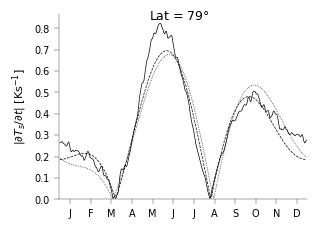

In [27]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(ds.time, np.abs(np.gradient(ds.t_surf)), color='k', label='Simulated')
ax.plot(ds.time, np.abs(np.gradient(temp_fourier_fit['linear'])), color='k', linestyle=':')
ax.plot(ds.time, np.abs(np.gradient(temp_fourier_fit['square'])), color='k', linestyle='--')
ax.set_xticks(*month_ticks)
ax.set_xlim(-1, 360)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('$|\partial T_s / \partial t|$ [Ks$^{-1}$]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

## Theoretical Temperature Distribution
Below, I plot how well we can predict the temperature distribution, from the simplified surface energy budget.

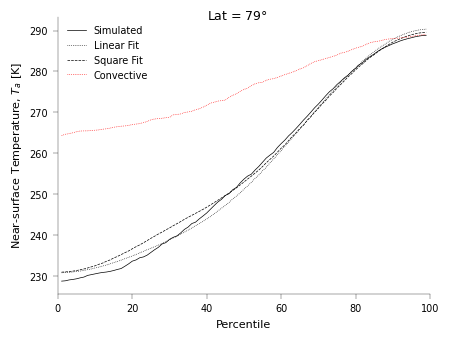

In [28]:
quant_plot = np.arange(1, 100)
fig, ax = plt.subplots(1,1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar))
ax.plot(quant_plot, ds.temp.quantile(quant_plot/100), color='k', label='Simulated')
ax.plot(quant_plot, (temp_fourier_fit['linear']+ds.temp.mean()).quantile(quant_plot/100), color='k', linestyle=':', label='Linear Fit')
ax.plot(quant_plot, (temp_fourier_fit['square']+ds.temp.mean()).quantile(quant_plot/100), color='k', linestyle='--', label='Square Fit')
# (temp_fourier_fit['square_no_conv']+ds.temp.mean()).quantile(quant_plot/100).plot(color='g', linestyle='--', label='Square Fit (non convecting)')
# (temp_fourier_fit['linear_no_conv']+ds.temp.isel(pfull=ind_surf).mean()).quantile(quant_plot/100).plot()
ax.plot(quant_plot, np.quantile(temp_surf_conv, quant_plot/100), color='r', linestyle=':', label='Convective')
ax.legend()
ax.set_ylabel('Near-surface Temperature, $T_a$ [K]')
ax.set_xlabel('Percentile')
ax.set_xlim(0, 100)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);